In [1]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)
import seaborn as sns

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PowerTransformer

import lightgbm as lgbm


In [2]:
sys.path.append('../../')
import src.utils as utils

In [3]:
EXP_NUM = 1

In [4]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [5]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()
seasons = pd.read_csv(MAIN_DATA_DIR / 'seasons.csv')


In [6]:
seasons = seasons.fillna('1970-01-01')
for c_ in seasons.columns[1:]:
    seasons[c_] = pd.to_datetime(seasons[c_].str.replace('-', '').astype(int), format="%Y%m%d")

In [7]:
seasons

,seasonId,seasonStartDate,seasonEndDate,preSeasonStartDate,preSeasonEndDate,regularSeasonStartDate,regularSeasonEndDate,lastDate1stHalf,allStarDate,firstDate2ndHalf,postSeasonStartDate,postSeasonEndDate
0,2017,2017-04-02,2017-11-01,2017-02-22,2017-04-01,2017-04-02,2017-10-01,2017-07-09,2017-07-11,2017-07-14,2017-10-03,2017-11-01
1,2018,2018-03-29,2018-10-28,2018-02-21,2018-03-27,2018-03-29,2018-10-01,2018-07-15,2018-07-17,2018-07-19,2018-10-02,2018-10-28
2,2019,2019-03-20,2019-10-30,2019-02-21,2019-03-26,2019-03-20,2019-09-29,2019-07-07,2019-07-09,2019-07-11,2019-10-01,2019-10-30
3,2020,2020-07-23,2020-10-28,2020-02-21,2020-07-22,2020-07-23,2020-09-27,2020-08-25,1970-01-01,2020-08-26,2020-09-29,2020-10-28
4,2021,2021-02-28,2021-10-31,2021-02-28,2021-03-30,2021-04-01,2021-10-03,2021-07-11,2021-07-13,2021-07-15,2021-10-04,2021-10-31


In [8]:
player_target_stats = pd.read_csv(MAIN_DATA_DIR / "player_target_stats.csv")

In [9]:
oof_gameday = pd.read_csv('./output/oof55_gameday.csv')
oof_notgameday = pd.read_csv('./output/oof55_notgameday.csv')
oof = pd.read_csv('../50/output/oof50.csv')


In [10]:
# oof = pd.merge(oof, oof_notgameday, how='left', on=['playerId', 'date'], suffixes=['', '_notgameday'])
# oof['target1'][~oof['target1_notgameday'].isna()] = oof['target1_notgameday']
# oof['target2'][~oof['target2_notgameday'].isna()] = oof['target2_notgameday']
# oof['target3'][~oof['target3_notgameday'].isna()] = oof['target3_notgameday']
# oof['target4'][~oof['target4_notgameday'].isna()] = oof['target4_notgameday']
# oof = oof.iloc[:, :7]
# oof

In [11]:
oof = pd.concat([oof_gameday, oof_notgameday])
oof

,Unnamed: 0,playerId,target1,target2,target3,target4,date
0,233,282332,2.999639,9.106012,8.113882,18.519050,20191013
1,234,282332,3.930825,9.106012,9.208926,21.003250,20191017
2,986,407845,0.006093,2.954512,0.385932,3.316931,20191003
3,987,407845,0.652888,2.954512,0.186175,3.584948,20191006
4,988,407845,0.385944,2.977051,0.168250,4.253679,20191014
...,...,...,...,...,...,...,...
268784,1051958,685503,0.009472,1.762978,0.049150,0.657840,20210424
268785,1051959,685503,0.010085,1.762978,0.048986,0.727480,20210426
268786,1051960,685503,0.009186,1.762978,0.048986,0.705554,20210427
268787,1051961,685503,0.009166,1.762978,0.048986,0.728584,20210428


In [12]:
oof = pd.merge(oof, targets, how='left', on=['playerId', 'date'])
oof

,Unnamed: 0,playerId,target1_x,target2_x,target3_x,target4_x,date,engagementMetricsDate,target1_y,target2_y,target3_y,target4_y,index
0,233,282332,2.999639,9.106012,8.113882,18.519050,20191013,2019-10-14,1.820075,22.976995,1.958850,17.460518,650
1,234,282332,3.930825,9.106012,9.208926,21.003250,20191017,2019-10-18,67.066231,41.654075,100.000000,100.000000,654
2,986,407845,0.006093,2.954512,0.385932,3.316931,20191003,2019-10-04,0.034840,7.326971,1.604013,9.487007,640
3,987,407845,0.652888,2.954512,0.186175,3.584948,20191006,2019-10-07,0.681967,4.580645,0.077479,7.640428,643
4,988,407845,0.385944,2.977051,0.168250,4.253679,20191014,2019-10-15,1.215036,9.572659,0.086606,7.216397,651
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305023,1051958,685503,0.009472,1.762978,0.049150,0.657840,20210424,2021-04-25,0.068494,15.961516,0.043568,1.492797,1209
305024,1051959,685503,0.010085,1.762978,0.048986,0.727480,20210426,2021-04-27,0.044617,1.224728,0.009437,0.737463,1211
305025,1051960,685503,0.009186,1.762978,0.048986,0.705554,20210427,2021-04-28,0.019123,1.178880,0.013161,0.790301,1212
305026,1051961,685503,0.009166,1.762978,0.048986,0.728584,20210428,2021-04-29,0.015799,4.323489,0.002350,0.970273,1213


In [13]:
oof = pd.merge(oof, scores, how='left', on=['playerId', 'date']) 


In [14]:
oof['gameday'] = ~oof['battingOrder'].isna()*1

In [15]:
len(oof[oof['gameday'] ==1]), len(oof[oof['gameday'] ==0])

(36239, 268789)

In [16]:
mae = mean_absolute_error(oof.iloc[:, 2:6], oof.iloc[:, 8:12])
print("mae:", mae)

mae: 0.7437245803068053


In [17]:
tr_idxs = []
val_idxs = []
tr_idx = (oof['date'].astype(int) < 20191001)
val_idx = (oof['date'].astype(int) >= 20191001) & (oof['date'].astype(int) < 20191030)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (oof['date'].astype(int) < 20200801)
val_idx = (oof['date'].astype(int) >= 20200801) & (oof['date'].astype(int) < 20200901)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (oof['date'].astype(int) < 20200901)
val_idx = (oof['date'].astype(int) >= 20200901) & (oof['date'].astype(int) < 20201001)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (oof['date'].astype(int) < 20201001)
val_idx = (oof['date'].astype(int) >= 20201001) & (oof['date'].astype(int) < 20201030)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)


tr_idx = (oof['date'].astype(int) < 20210401)
val_idx = ~tr_idx
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

In [18]:
mae = mean_absolute_error(oof[val_idxs[0]].iloc[:, 2:6], oof[val_idxs[0]].iloc[:, 8:12])
print("fold1 mae:", mae)
mae = mean_absolute_error(oof[val_idxs[1]].iloc[:, 2:6], oof[val_idxs[1]].iloc[:, 8:12])
print("fold2 mae:", mae)
mae = mean_absolute_error(oof[val_idxs[2]].iloc[:, 2:6], oof[val_idxs[2]].iloc[:, 8:12])
print("fold3 mae:", mae)
mae = mean_absolute_error(oof[val_idxs[3]].iloc[:, 2:6], oof[val_idxs[3]].iloc[:, 8:12])
print("fold4 mae:", mae)
mae = mean_absolute_error(oof[val_idxs[4]].iloc[:, 2:6], oof[val_idxs[4]].iloc[:, 8:12])
print("fold5 mae:", mae)

fold1 mae: 0.43853683771726687
fold2 mae: 0.9537996190275151
fold3 mae: 0.9347239288320293
fold4 mae: 0.4371797982959814
fold5 mae: 0.916770972816838


In [19]:
mae = mean_absolute_error(oof[oof['gameday']==1].iloc[:, 2:6], oof[oof['gameday']==1].iloc[:, 8:12])
print("gameday_mae:", mae)
mae = mean_absolute_error(oof[oof['gameday']==0].iloc[:, 2:6], oof[oof['gameday']==0].iloc[:, 8:12])
print("notgameday_mae:", mae)

gameday_mae: 2.653050048722384
notgameday_mae: 0.48630316183390604


In [81]:
targets_5 = targets[(targets['date']>20190501) & (targets['date']<=20190531)]
targets_5 = pd.merge(targets_5, scores, how='left', on=['playerId', 'date'])
targets_5['gameday'] = ~targets_5['battingOrder'].isna()*1
len(targets_5[targets_5['gameday'] ==1]), len(targets_5[targets_5['gameday'] ==0])

(11226, 50604)

In [22]:
from scipy import stats

0.5775100972283256

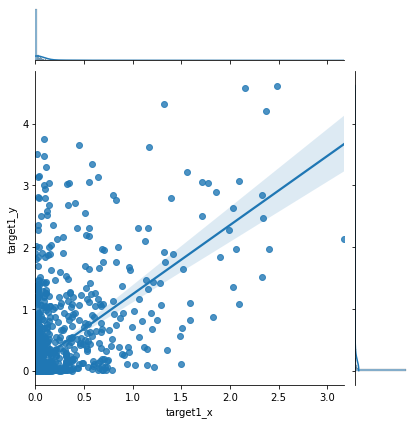

In [32]:
x_ = np.log(oof["target1_x"][::100]+1)
y_ = np.log(oof["target1_y"][::100]+1)
sns.jointplot(x=x_, y=y_, kind="reg")
np.corrcoef(x_, y_)[0, 1]

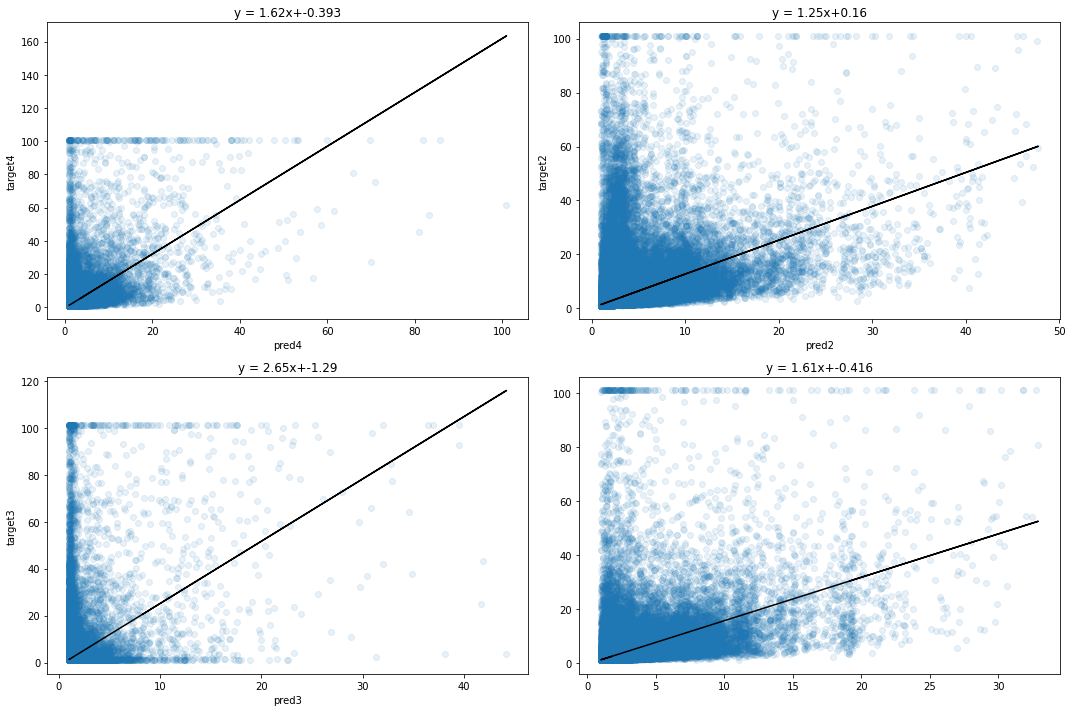

In [195]:
from sklearn import linear_model


fig = plt.figure(figsize=(15, 10))

pred_x = (oof["target1_x"]+1).values.reshape(-1,1)
target_x = (oof["target1_y"]+1).values.reshape(-1,1)
reg1 = linear_model.LinearRegression()
reg1.fit(pred_x, target_x)
ax1 = fig.add_subplot(221)
ax1.plot(pred_x, reg1.predict(pred_x), color='black')
ax1.scatter(pred_x, target_x, alpha=0.1)
ax1.set_xlabel('pred1')
ax1.set_ylabel('target1')
ax1.set_title('y = {:.3g}x+{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]))


pred_x = (oof["target2_x"]+1).values.reshape(-1,1)
target_x = (oof["target2_y"]+1).values.reshape(-1,1)
reg1 = linear_model.LinearRegression()
reg1.fit(pred_x, target_x)
ax2 = fig.add_subplot(222)
ax2.plot(pred_x, reg1.predict(pred_x), color='black')
ax2.scatter(pred_x, target_x, alpha=0.1)
ax2.set_xlabel('pred2')
ax2.set_ylabel('target2')
ax2.set_title('y = {:.3g}x+{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]))

pred_x = (oof["target3_x"]+1).values.reshape(-1,1)
target_x = (oof["target3_y"]+1).values.reshape(-1,1)
reg1 = linear_model.LinearRegression()
reg1.fit(pred_x, target_x)
ax3 = fig.add_subplot(223)
ax3.plot(pred_x, reg1.predict(pred_x), color='black')
ax3.scatter(pred_x, target_x, alpha=0.1)
ax3.set_xlabel('pred3')
ax3.set_ylabel('target3')
ax3.set_title('y = {:.3g}x+{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]))

pred_x = (oof["target4_x"]+1).values.reshape(-1,1)
target_x = (oof["target4_y"]+1).values.reshape(-1,1)
reg1 = linear_model.LinearRegression()
reg1.fit(pred_x, target_x)
ax4 = fig.add_subplot(224)
ax4.plot(pred_x, reg1.predict(pred_x), color='black')
ax4.scatter(pred_x, target_x, alpha=0.1)
ax1.set_xlabel('pred4')
ax1.set_ylabel('target4')
ax4.set_title('y = {:.3g}x+{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]))

plt.tight_layout()